In [ ]:
import os
import pandas as pd
from PIL import Image
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

# обработка датасета:

image_data = []
labels = []
drive.mount('/content/drive')

def process_images(path):
    for filename in os.listdir(path):
      if filename.endswith('jpg'):
        # print(filename)
        image_path = os.path.join(path, filename)
        img = Image.open(image_path)
        grays_img = img.convert('L')  # в чб
        resized_img = grays_img.resize((8, 8))  # resize image
        # print(img.size)
        image_data.append(list(resized_img.getdata()))
        labels.append(filename.split('_')[0])  # значение (сами буквы)

process_images('/content/drive/MyDrive/ing/hangul_characters_v1')

columns = [f"pixel_{i}" for i in range(len(image_data[0]))]
df = pd.DataFrame(image_data, columns=columns)
df['label0'] = labels  # target names (в исходном ходе называется)

df.to_csv('hangul.csv', index=False)

# print(df.head(), df.shape)
le = LabelEncoder()
encod = le.fit_transform(df['label0'].values)  # в цифры трансформируем
df['label1'] = encod

Mounted at /content/drive


In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.preprocessing import StandardScaler

# X_scale = StandardScaler()
# X = X_scale.fit_transform(df.iloc[:,0:64])
X = df.iloc[:,0:64]
y = encod
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4)

# X_train = X_train.reshape(1440, 64)
# X_test = X_test.reshape(960, 64)
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
# X_train /= 255
# X_test /= 255

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_train= X_train.to_numpy()
X_test= X_test.to_numpy()

X_train = X_train.reshape(1440, 64).astype('float32')
X_test = X_test.reshape(960, 64).astype('float32')

print(X_train[0])
y_train = to_categorical(y_train, 30)
y_test = to_categorical(y_test, 30)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot as plt

np.random.seed(1671)
print(X_train.shape, X_test.shape)
CLASSES = 30
EPOCHS = 150
BATCH_SIZE = 128
# OPTIMIZER = SGD()
# OPTIMIZER = RMSprop()
OPTIMIZER = Adam(learning_rate=0.01)
VALIDATION_SPLIT = 0.001
HIDDEN = 210
DROPOUT = 0.2

model = Sequential()
# model.add(Dense(CLASSES, input_shape = (64, )))
model.add(Dense(HIDDEN, input_shape = (64, )))
model.add(Activation('relu'))
# model.add(Flatten())
model.add(Dense(HIDDEN))
model.add(Activation('relu'))

model.add(Dense(CLASSES))
# model.add(Activation('softmax'))
model.add(Activation('softmax'))  # функция активации softmax

model.summary()

model.compile(loss = 'categorical_crossentropy',  # классифик. функция потерь
              optimizer = OPTIMIZER,
              metrics = ['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size = BATCH_SIZE, epochs = EPOCHS,
                    validation_split = VALIDATION_SPLIT)

(1440, 64) (960, 64)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_130 (Dense)           (None, 210)               13650     
                                                                 
 activation_130 (Activation  (None, 210)               0         
 )                                                               
                                                                 
 dense_131 (Dense)           (None, 210)               44310     
                                                                 
 activation_131 (Activation  (None, 210)               0         
 )                                                               
                                                                 
 dense_132 (Dense)           (None, 30)                6330      
                                                                 
 activation_132 (Activation  (No

30/30 [==============================] - 0s 2ms/step - loss: 0.4978 - accuracy: 0.9177
Test score: 0.4977533519268036
test accuracy: 0.9177083373069763


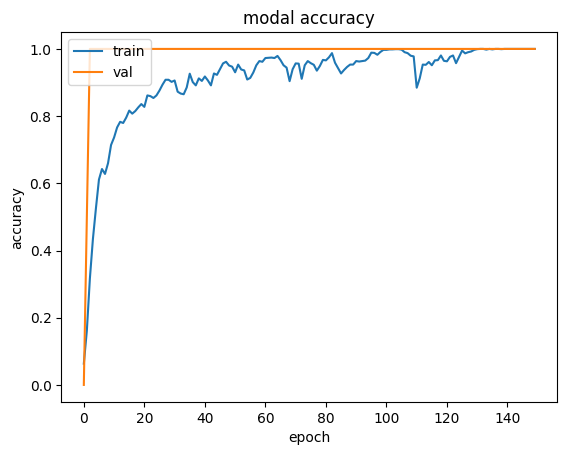

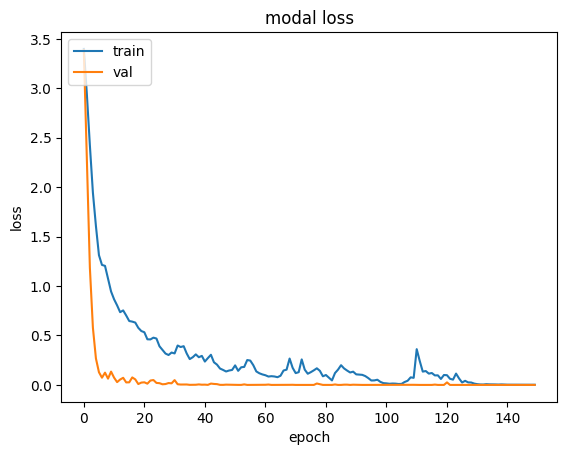

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 1)
print(f'Test score:', score[0])
print(f'test accuracy:', score[1])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('modal accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('modal loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()